In [1]:
import SimpleITK as sitk
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display_image(img):
    plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
    plt.axis("off")

def overlay_fixed_moving(fixed, moving):
    img1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    img2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    cimg = sitk.Compose(img1, img2, sitk.Cast(img1/2. + img2/2., sitk.sitkUInt8))
    plt.imshow(sitk.GetArrayFromImage(cimg))
    plt.axis("off")

# Hello World

This example illustrates how to use SimpleElastix. With a single function call we can specify the fixed image, the moving image and the type of registration you want to perform. SimpleElastix will then register our images using sensible default parameters that work well in most cases. In later examples we shall see how to tweak the default parameters, but for now we keep it simple.

## Registration With Translation Transform

Say we want to register the following two brain MRIs.

In [3]:
dataPath = os.path.join(os.sep, "Users", "tannersorensen", "SimpleElastix-fork", \
                        "SimpleElastix-build", "SimpleITK-build", "ExternalData", \
                        "Testing", "Data", "Input")

fixedFilename = "BrainProtonDensitySliceBorder20.png"
fixedImage = sitk.ReadImage(os.path.join(dataPath, fixedFilename), sitk.sitkUInt8)

movingFilename = "BrainProtonDensitySliceShifted13x17y.png"
movingImage = sitk.ReadImage(os.path.join(dataPath, movingFilename), sitk.sitkUInt8)

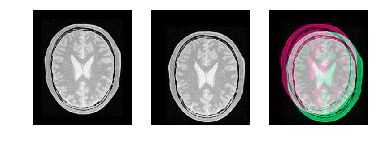

In [4]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# moving image
plt.subplot(1,3,2)
display_image(movingImage)

# fixed image (red) and moving image (green),
# with overlap in white
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, movingImage)

We identify that the objects are related by a simple spatial shift and that a translation transform should be sufficient to align the objects. To correct the misalignment, we run the following lines of python code:

In [5]:
resultImage = sitk.Elastix(fixedImage, movingImage, "translation")

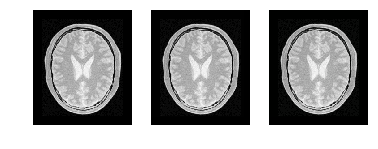

In [6]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# registered moving image (result)
plt.subplot(1,3,2)
display_image(resultImage)

# fixed image (red) and registered 
# moving image (green), with overlap in white
# note that the images completely overlap
# (i.e., no red or green)
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, resultImage)

That’s it! We have effectively registered two images using a single line of code. Compare this to the [ITK Hello World example](https://github.com/InsightSoftwareConsortium/ITK/blob/master/Examples/RegistrationITKv4/DeformableRegistration1.cxx). We refer to this short-hand notation as the procedural interface (some people also refer to it as the functional interface) because it consists of functions that accomplish a specific task. The procedural interface is less flexible than the object-oriented interface introduced below, but it is very simple to use. Let’s break down what goes on under the hood of this single function call.

First of all, `import SimpleITK as sitk` loads the SimpleITK module from which SimpleElastix is accessed. This assumes that SimpleElastix has been compiled and installed on your machine.

`sitk.ReadImage()` is the generic image file reader of SimpleITK which loads an image from disk and pass a SimpleITK image object to SimpleElastix. You can also apply a SimpleITK filter to an image before passing them to SimpleElastix. For example, you could use the `ResampleImageFilter()` to downsample images that would otherwise consume too much memory during registration.

The final parameter `"translation"` specifies the desired type of registration. In the Parameter Maps section we will take a close look at parameter maps and examine what happens when you specify this parameter. It is obvious from the figure below that a translation transform is sufficient to align these images.

## Object-Oriented Interface

The example above used procedural interface. While the procedural interface may be useful for rapid prototyping, it trades off flexibility for code simplicity. For example, the final deformation field cannot be retrived and applied to another image. This is a problem if we want to subsequently warp other images, e.g. a label image, using the same transformation. Further, image quality is reduced from resampling the resulting image twice. To this end, SimpleElastix comes with a more flexible object-oriented interface suitable for more advanced use cases and scripting purposes. In the next example, we perform the same registration as above, but this time using the object oriented interface:

In [7]:
parameterMap = sitk.GetDefaultParameterMap("translation")

elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(parameterMap)
elastixImageFilter.Execute()

resultImage = elastixImageFilter.GetResultImage()
transformParameterMap = elastixImageFilter.GetTransformParameterMap()

This is more verbose but also a lot more powerful. We can now warp an entire population of images (e.g. binary label images for segmentation of different brain regions) using the same parameter map and a single instance of transformix:

In [8]:
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetTransformParameterMap(transformParameterMap)

population = [movingFilename, movingFilename, movingFilename, movingFilename]

for filename in population:
    transformixImageFilter.SetMovingImage(sitk.ReadImage(os.path.join(dataPath, filename)))
    transformixImageFilter.Execute()
    sitk.WriteImage(sitk.Cast(transformixImageFilter.GetResultImage(), sitk.sitkUInt8), "result_"+filename)

The object-oriented interface facilitates reuse of components and dramatically simplifies book-keeping and boilerplate code. We will use the object-oriented interface in the documentation from this point forward.

In the next section, we will take a closer look at the parameter map interface that configures the registration components.